# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D), with DPSGD
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables
conda install -c conda-forge opacus

In [9]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it


## Train the classifier
### Load the dataset
The dataset is generated by the notebook file `mimic_dataset_prep.ipynb`.\
In `train_config.yaml` set the `training_method` to `GRUD_DPSGD`. 

In [10]:
import os
import yaml
import pickle

# Load the config.yaml file
with open("train_config.yaml", "r") as file:
    train_config = yaml.safe_load(file)

# Determine training method and paths
#TODO: DO we want GRUD traning mode in the config file or not?
assert train_config['train']['training_method'] == 'GRUD', "The training config is not set to GRUD"
use_LR = False
data_path = train_config['data']['data_dir']
path = os.path.join(data_path, "LR_data" if use_LR else "GRUD_data")

# File paths
dataset_path = os.path.join(path, "dataset.pkl")
indices_path = os.path.join(path, "indices.pkl")

# Load dataset and indices
if os.path.exists(dataset_path) and os.path.exists(indices_path):
    print("Loading dataset...")
    
    with open(dataset_path, "rb") as f:
        dataset = pickle.load(f)

    with open(indices_path, "rb") as f:
        indices_dict = pickle.load(f)
        train_indices = indices_dict["train_indices"]
        test_indices = indices_dict["test_indices"]
        early_stop_indices = indices_dict["early_stop_indices"]
        #TODO: fix this
        data_indices = train_indices + test_indices + early_stop_indices

    print(f"Loaded dataset and indices from {path}")
else:
    raise FileNotFoundError("Dataset not found.\n→ Run 'mimic_dataset_prep.ipynb' to generate the required dataset.\n")


Loading dataset...
Loaded dataset and indices from ./data/GRUD_data


Create dala loaders. The  `batch_size` is one of the parameters which is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [11]:
from torch.utils.data import DataLoader
from mimic_data_handler import MIMICUserDataset


data = dataset.data
targets = dataset.targets

train_subset = MIMICUserDataset(data[train_indices], targets[train_indices])
test_subset = MIMICUserDataset(data[test_indices], targets[test_indices])
early_stop_subset = MIMICUserDataset(data[early_stop_indices], targets[early_stop_indices])

# Create DataLoaders
batch_size = 59
train_loader = DataLoader(train_subset, batch_size=batch_size)
test_loader = DataLoader(test_subset, batch_size=batch_size)
early_stop_loader = DataLoader(early_stop_subset, batch_size=batch_size)


The `optimized_hyperparams` is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [12]:
optimized_hyperparams ={
    "hidden_size": 78,
    "learning_rate": 0.00473,
    "num_epochs":40,
    "patience_early_stopping": 40,
    "patience_lr_scheduler": 3,
    "batch_size": batch_size,
    "seed": 4410,
    "min_delta": 0.00001,
    }

## Setting Hyperparameters for Differential Privacy via Opacus

### Noise Multiplier Configuration for Privacy Analysis

In this code block, we configure the parameters necessary for calculating the noise multiplier using the **Opacus** library, which we used for differential privacy analysis. 

- **`target_epsilon`**: The desired epsilon value.
- **`target_delta`**: The delta value indicating the risk of privacy loss.
- **`sample_rate`**: The rate at which data points are used in training.
- **`epochs`**: The number of training epochs for the model.
- **`epsilon_tolerance`**: A small margin for the epsilon value,
- **`accountant`**: Specifies the method of tracking privacy loss, with "prv" referring to the Privacy Accountant for DPSGD.
- **`eps_error`**: The allowable error in epsilon calculations
- **`max_grad_norm`**: A limit on the gradient norm to ensure the gradients do not explode during training.

The most common hyperparameters to tune are `target_epsilon`, `sample_rate`, `noise_multiplier`, and `max_grad_norm`. These parameters should be inputed by the user based on thier need for balancing privacy and utility.


In [13]:
import os
import pickle

noise_multiplier_dict = {
    "target_epsilon": 3.5,
    "target_delta": 1e-5,
    "sample_rate": 1/len(train_loader),
    "epochs": 40,
    "epsilon_tolerance": 0.01,
    "accountant": "prv",
    "eps_error": 0.01,
    "max_grad_norm": 1,
}

# Path to save the pickle file
dpsgd_path = "./target_GRUD_dpsgd/dpsgd_dic.pkl"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(dpsgd_path), exist_ok=True)

# Save to a file
with open(dpsgd_path, "wb") as f:
    pickle.dump(noise_multiplier_dict, f)


In [14]:
from torch import  nn, optim, save, zeros
from mimic_model_handler import GRUHandler
from target_models import GRUD
import os
import pickle
from opacus.validators import ModuleValidator
from opacus.grad_sample import GradSampleModule

# Add other required parameters to model_params
model_params = {
    "hidden_size": optimized_hyperparams["hidden_size"],
    "batch_size": optimized_hyperparams["batch_size"],
    "input_size": int(data.shape[1]/3),
    "X_mean":  zeros(1,data.shape[2],int(data.shape[1]/3)),
    "output_last": False,
    "bn_flag": False,
    "batch_first" : True,
    "loss_reduction": "none", # "none" to use with DP-SGD
    "force_functorch": True,
}

# Initialize the model with filtered parameters
model = GRUD(**model_params)
 
# replace unsupported layers (like BatchNorm) with DP-compliant alternatives (like GroupNorm). 
model = ModuleValidator.fix(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=optimized_hyperparams["learning_rate"])

# Train the model
train_results = GRUHandler().train_with_dpsgd(train_loader,
                                    model,
                                    criterion,
                                    optimizer,
                                    optimized_hyperparams["num_epochs"],
                                    early_stop_loader,
                                    optimized_hyperparams["patience_early_stopping"],
                                    optimized_hyperparams["patience_lr_scheduler"],
                                    optimized_hyperparams["min_delta"],
                                    )

# Evaluate the model
test_results = GRUHandler().eval(test_loader, model, criterion)


# Store model and its metadata
model = train_results.model
model.to("cpu")

state_dict = model.state_dict()
if isinstance(model, GradSampleModule):
    # Clean wrapped keys like "_module.zl.weight" → "zl.weight"
    state_dict = {k.replace("_module.", ""): v for k, v in state_dict.items()}
else:
    warnings.warn(
        "The model is not wrapped with GradSampleModule — likely trained without Opacus/DP-SGD. "
        "Proceeding to save state_dict as-is.",
        UserWarning
    )

target_dir = "target_GRUD_dpsgd"
os.makedirs(target_dir, exist_ok=True)
with open(target_dir+"/target_model.pkl", "wb") as f:
    save(state_dict, f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_results,
                                    optimizer = optimizer,
                                    loss_fn = criterion,
                                    dataloader = train_loader,
                                    test_result = test_results,
                                    epochs = optimized_hyperparams["num_epochs"],
                                    train_indices = train_indices,
                                    test_indices = test_indices,
                                    dataset_name = train_config["data"]["dataset"])

with open(target_dir + "/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)

/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/utils/module_utils.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  module_copy = torch.

Training shadow models with DP-SGD


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
Training Progress:   0%|          | 0/40 [00:00<?, ?it/s]/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:   2%|▎         | 1/40 [00:12<07:55, 12.19s/it]

Epoch 0: Validation loss improved to 0.8526
Learning Rate: 0.004730000000
Epoch: 0, train_loss: 0.83733402, train_acc: 0.63311525


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:   5%|▌         | 2/40 [00:24<07:47, 12.30s/it]

Epoch 1: No improvement. Patience counter: 1/40
Learning Rate: 0.004730000000
Epoch: 1, train_loss: 0.96449745, train_acc: 0.65812598


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:   8%|▊         | 3/40 [00:36<07:34, 12.27s/it]

Epoch 2: No improvement. Patience counter: 2/40
Learning Rate: 0.004730000000
Epoch: 2, train_loss: 0.98103081, train_acc: 0.66187356


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  10%|█         | 4/40 [00:49<07:21, 12.26s/it]

Epoch 3: No improvement. Patience counter: 3/40
Learning Rate: 0.004730000000
Epoch: 3, train_loss: 0.97329882, train_acc: 0.67353446


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  12%|█▎        | 5/40 [01:01<07:08, 12.26s/it]

Epoch 4: No improvement. Patience counter: 4/40
Learning Rate: 0.000946000000
Epoch: 4, train_loss: 0.97802888, train_acc: 0.6729445


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  15%|█▌        | 6/40 [01:13<06:56, 12.26s/it]

Epoch 5: No improvement. Patience counter: 5/40
Learning Rate: 0.000946000000
Epoch: 5, train_loss: 1.02741646, train_acc: 0.66647245


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  18%|█▊        | 7/40 [01:25<06:44, 12.26s/it]

Epoch 6: No improvement. Patience counter: 6/40
Learning Rate: 0.000946000000
Epoch: 6, train_loss: 1.01917462, train_acc: 0.66886643


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  20%|██        | 8/40 [01:38<06:33, 12.31s/it]

Epoch 7: No improvement. Patience counter: 7/40
Learning Rate: 0.000946000000
Epoch: 7, train_loss: 0.98132512, train_acc: 0.6770543


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  22%|██▎       | 9/40 [01:50<06:21, 12.30s/it]

Epoch 8: No improvement. Patience counter: 8/40
Learning Rate: 0.000189200000
Epoch: 8, train_loss: 0.98537396, train_acc: 0.6763548


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  25%|██▌       | 10/40 [02:02<06:04, 12.13s/it]

Epoch 9: No improvement. Patience counter: 9/40
Learning Rate: 0.000189200000
Epoch: 9, train_loss: 0.98197058, train_acc: 0.67568013


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  28%|██▊       | 11/40 [02:14<05:49, 12.06s/it]

Epoch 10: No improvement. Patience counter: 10/40
Learning Rate: 0.000189200000
Epoch: 10, train_loss: 0.99152394, train_acc: 0.67548017


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  30%|███       | 12/40 [02:26<05:38, 12.09s/it]

Epoch 11: No improvement. Patience counter: 11/40
Learning Rate: 0.000189200000
Epoch: 11, train_loss: 1.00910947, train_acc: 0.67046581


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  32%|███▎      | 13/40 [02:38<05:27, 12.14s/it]

Epoch 12: No improvement. Patience counter: 12/40
Learning Rate: 0.000037840000
Epoch: 12, train_loss: 0.9983349, train_acc: 0.67271823


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  35%|███▌      | 14/40 [02:50<05:15, 12.14s/it]

Epoch 13: No improvement. Patience counter: 13/40
Learning Rate: 0.000037840000
Epoch: 13, train_loss: 0.99984959, train_acc: 0.66947456


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  38%|███▊      | 15/40 [03:02<05:03, 12.14s/it]

Epoch 14: No improvement. Patience counter: 14/40
Learning Rate: 0.000037840000
Epoch: 14, train_loss: 1.00739184, train_acc: 0.6716832


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  40%|████      | 16/40 [03:15<04:51, 12.14s/it]

Epoch 15: No improvement. Patience counter: 15/40
Learning Rate: 0.000037840000
Epoch: 15, train_loss: 0.96909051, train_acc: 0.68166263


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  42%|████▎     | 17/40 [03:27<04:39, 12.15s/it]

Epoch 16: No improvement. Patience counter: 16/40
Learning Rate: 0.000007568000
Epoch: 16, train_loss: 0.98699087, train_acc: 0.67746255


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  45%|████▌     | 18/40 [03:39<04:27, 12.18s/it]

Epoch 17: No improvement. Patience counter: 17/40
Learning Rate: 0.000007568000
Epoch: 17, train_loss: 0.981534, train_acc: 0.6756712


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  48%|████▊     | 19/40 [03:51<04:15, 12.18s/it]

Epoch 18: No improvement. Patience counter: 18/40
Learning Rate: 0.000007568000
Epoch: 18, train_loss: 0.98157629, train_acc: 0.67658398


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  50%|█████     | 20/40 [04:03<04:03, 12.17s/it]

Epoch 19: No improvement. Patience counter: 19/40
Learning Rate: 0.000007568000
Epoch: 19, train_loss: 0.99577793, train_acc: 0.66958793


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  52%|█████▎    | 21/40 [04:15<03:51, 12.16s/it]

Epoch 20: No improvement. Patience counter: 20/40
Learning Rate: 0.000001513600
Epoch: 20, train_loss: 0.98523055, train_acc: 0.67928954


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  55%|█████▌    | 22/40 [04:28<03:38, 12.15s/it]

Epoch 21: No improvement. Patience counter: 21/40
Learning Rate: 0.000001513600
Epoch: 21, train_loss: 0.99086797, train_acc: 0.66933378


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  57%|█████▊    | 23/40 [04:40<03:26, 12.18s/it]

Epoch 22: No improvement. Patience counter: 22/40
Learning Rate: 0.000001513600
Epoch: 22, train_loss: 0.99985041, train_acc: 0.67473702


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  60%|██████    | 24/40 [04:52<03:14, 12.15s/it]

Epoch 23: No improvement. Patience counter: 23/40
Learning Rate: 0.000001513600
Epoch: 23, train_loss: 0.99666032, train_acc: 0.66975803


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  62%|██████▎   | 25/40 [05:04<03:02, 12.15s/it]

Epoch 24: No improvement. Patience counter: 24/40
Learning Rate: 0.000000302720
Epoch: 24, train_loss: 0.99040015, train_acc: 0.67427368


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  65%|██████▌   | 26/40 [05:16<02:49, 12.14s/it]

Epoch 25: No improvement. Patience counter: 25/40
Learning Rate: 0.000000302720
Epoch: 25, train_loss: 0.94515561, train_acc: 0.6856313


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  68%|██████▊   | 27/40 [05:28<02:37, 12.13s/it]

Epoch 26: No improvement. Patience counter: 26/40
Learning Rate: 0.000000302720
Epoch: 26, train_loss: 0.98755329, train_acc: 0.67400698


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  70%|███████   | 28/40 [05:40<02:25, 12.16s/it]

Epoch 27: No improvement. Patience counter: 27/40
Learning Rate: 0.000000302720
Epoch: 27, train_loss: 0.9632122, train_acc: 0.68483412


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  72%|███████▎  | 29/40 [05:52<02:13, 12.13s/it]

Epoch 28: No improvement. Patience counter: 28/40
Learning Rate: 0.000000060544
Epoch: 28, train_loss: 0.99000529, train_acc: 0.67981205


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  75%|███████▌  | 30/40 [06:05<02:01, 12.11s/it]

Epoch 29: No improvement. Patience counter: 29/40
Learning Rate: 0.000000060544
Epoch: 29, train_loss: 0.97603586, train_acc: 0.67738406


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  78%|███████▊  | 31/40 [06:17<01:48, 12.10s/it]

Epoch 30: No improvement. Patience counter: 30/40
Learning Rate: 0.000000060544
Epoch: 30, train_loss: 1.00625953, train_acc: 0.673053


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  80%|████████  | 32/40 [06:29<01:36, 12.09s/it]

Epoch 31: No improvement. Patience counter: 31/40
Learning Rate: 0.000000060544
Epoch: 31, train_loss: 0.96345372, train_acc: 0.68296333


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  82%|████████▎ | 33/40 [06:41<01:24, 12.13s/it]

Epoch 32: No improvement. Patience counter: 32/40
Learning Rate: 0.000000012109
Epoch: 32, train_loss: 0.97869433, train_acc: 0.67867314


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  85%|████████▌ | 34/40 [06:53<01:12, 12.12s/it]

Epoch 33: No improvement. Patience counter: 33/40
Learning Rate: 0.000000012109
Epoch: 33, train_loss: 0.98374128, train_acc: 0.67551944


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  88%|████████▊ | 35/40 [07:05<01:00, 12.11s/it]

Epoch 34: No improvement. Patience counter: 34/40
Learning Rate: 0.000000012109
Epoch: 34, train_loss: 0.97955335, train_acc: 0.67764628


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  90%|█████████ | 36/40 [07:17<00:48, 12.11s/it]

Epoch 35: No improvement. Patience counter: 35/40
Learning Rate: 0.000000012109
Epoch: 35, train_loss: 0.98577528, train_acc: 0.67455328


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  92%|█████████▎| 37/40 [07:29<00:36, 12.11s/it]

Epoch 36: No improvement. Patience counter: 36/40
Learning Rate: 0.000000012109
Epoch: 36, train_loss: 0.97642263, train_acc: 0.6780439


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  95%|█████████▌| 38/40 [07:42<00:24, 12.15s/it]

Epoch 37: No improvement. Patience counter: 37/40
Learning Rate: 0.000000012109
Epoch: 37, train_loss: 0.97441959, train_acc: 0.6805075


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress:  98%|█████████▊| 39/40 [07:54<00:12, 12.14s/it]

Epoch 38: No improvement. Patience counter: 38/40
Learning Rate: 0.000000012109
Epoch: 38, train_loss: 0.98688315, train_acc: 0.67542104


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Progress: 100%|██████████| 40/40 [08:06<00:00, 12.16s/it]

Epoch 39: No improvement. Patience counter: 39/40
Learning Rate: 0.000000012109
Epoch: 39, train_loss: 0.9860507, train_acc: 0.67569358


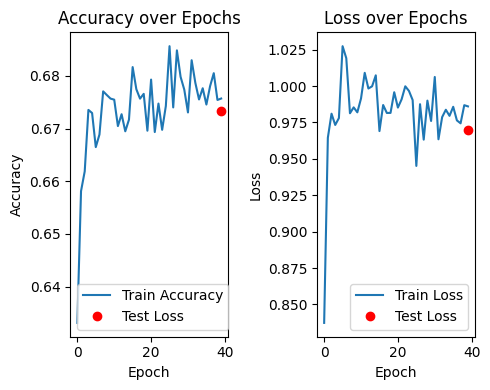

In [15]:
import matplotlib.pyplot as plt

train_acc = train_results.metrics.extra["accuracy_history"]
train_loss = train_results.metrics.extra["loss_history"]
test_acc = test_results.accuracy
test_loss = test_results.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

##  Attacking the GRUD model
Modify ```audit.yaml ``` file to attack GRUD model: 
  
  ```
  model_class: "GRUD"
  target_folder: "./target_GRUD_dpsgd"
  data_path: "./data/GRUD_data/dataset.pkl"
  ```

In [17]:
import os
import sys
from leakpro import LeakPro
from mimic_model_handler import GRUHandler as InputHandler

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it

# Read the config file
config_path = "audit.yaml"

# Instantiate leakpro object
leakpro = LeakPro(InputHandler, config_path)

# Run the audit 
mia_results = leakpro.run_audit(create_pdf=True)

2025-06-10 14:50:55,077 INFO     Target model blueprint created from GRUD in ./target_models.py.
06/10/2025 14:50:55:INFO:Target model blueprint created from GRUD in ./target_models.py.
2025-06-10 14:50:55,086 INFO     Loaded target model metadata from ./target_GRUD_dpsgd/model_metadata.pkl
06/10/2025 14:50:55:INFO:Loaded target model metadata from ./target_GRUD_dpsgd/model_metadata.pkl
/home/fazeleh/LeakPro/leakpro/input_handler/mia_handler.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to 

<Figure size 640x480 with 0 Axes>

## Generate report